## Signature Methods in Finance
### Part III: Signature and Functional Expansions
#### 6.2 A new Greek and fast computation of VaR


In [74]:
from quantLib import *
from math import factorial as fact
import matplotlib.pyplot as plt
from cycler import cycler as cyc
cols = ["midnightblue","indianred","darkred",'mediumpurple','tomato','indianred',"plum","gold","steelblue"]
colCyc = cyc('color', cols) #linestyle = ["-","--",":"])
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "palatino"
})
import bqplot.pyplot as bqplt
import ipywidgets as wi
from scipy.stats import norm, lognorm
from bqplot import Axis, LinearScale
import matplotlib.pyplot as plt
from cycler import cycler as cyc
__ = np.newaxis

In [75]:
def MC(G,T, r = 0.): 
    """Monte Carlo price of the reward G (array). 
       T = maturity, r = continuous interest rate. """
    return np.mean(np.exp(-r*T) * G,axis = -1)

### 6.1.1 Asian call option

$$    g(X) = \left(\bar{a}(X) - K \right)^+, \quad  \bar{a}(X) = \frac{1}{T}\int_0^t X_udu,  \quad X \in \Lambda_u. $$

In [210]:
x0      = 100     # Initial value
K,T     = x0,1/2  # Option parameters 
t       = T/2     # Today's date
r,sig   = 0.0,0.2 # Black-Scholes Parameters (no dividends)

# Itô map linking Brownian motion to the coordinate process Y 
# under Q (here Black-Scholes)
w2Y = lambda x,Ts,W: x * np.exp(sig * W + (r - sig**2/2) * Ts)

Y = w2Y(x0,Ts,BM(Ts,J))

# Payoff
g = lambda X: np.maximum(np.mean(X,axis = 0) - K,0.)

# Simulations
# Number of time steps
 # Time increment (here one day)
dt  = 1/252          
ts  = np.arange(0,T+dt,dt)  # Time grid (flat)
Ts  = ts[:,__]              # Time grid (column vector)                 

def PnL(dt,dy,A,lbda):
    """Taylor approximation of the P&L f(X*Y) - f(X) using the Greeks
       (Theta,Delta,Gamma,L)."""
    return lbda["t"] * T + lbda["x"] * dy + lbda["xx"] * dy**2/2 + lbda["[t,x]"] * A

    #return np.dot(greeks,np.array([dt,dy,dy**2/2,A]))


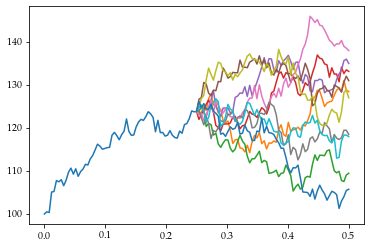

In [214]:
# Today's date (time step)
n = int(t/dt)
# Observed path 
X = w2Y(x0,Ts[:n+1],BM(Ts[:n+1],1))
# Shock
J = 10; Y = w2Y(X[-1],Ts[n:]-t,BM(Ts[n:]-t,J)) 
# Path 
Z = np.vstack([np.tile(X,(1,J)),Y])
#plt.plot(Ts,Z,"--",color = "k",zorder = 3)
plt.plot(Ts[:n+1],X)
plt.plot(Ts[n:],Y)
plt.show()

In [215]:
def f(t,X,J = int(1e5)):
    """Price functional f(X) = E[g(Z)|X]. 
       J = # Monte Carlo simulations"""
    # Shocks
    Ts_ = Ts[int(t/dt):]-t # time grid
    Y   = w2Y(X[-1,:],Ts_,BM(Ts_,J)) 
    # Concatenated paths
    Z = np.vstack([np.tile(X,(1,J)),Y])
    # Monte Carlo price
    return MC(g(Z),T)

In [223]:
# Today's date (time step)
n = int(t/dt)
# Observed path 
X = w2Y(x0,Ts[:n+1],BM(Ts[:n+1],1))
X[-1]
# Today's price
f_ = f(t,X)
# Functional derivatives (Greeks). Use finite difference
dx        = x0*1e-2#4
dx_       = dx * (Ts[:n+1] == t) # bump (column vector)
fUp,fDown = f(t,X + dx_),f(t,X - dx_) # bumped path at final time (up an down)
# Distorted paths for the Lie derivative
X_xt      = np.vstack([X,X[-1,:]]) + dx * (Ts[:n+2] == (t+dt)) 
X_tx      = np.vstack([X + dx_,X[-1,:]+ dx])

lbda = {"t"    : (f(t+dt,np.vstack([X,X[-1,:]])) - f_)/dt,
        "x"    : (fUp - f_)/dx,
        "xx"   : (fUp - 2*f_ + fDown)/dx**2, # butterfly approximation
        "[t,x]": (f(t+dt,X_xt) - f(t+dt,X_tx))/(dt*dx) } # Lie derivative

In [1]:
# Check 
plt.plot(Ts[:n+1],X,label = None)
plt.step(Ts[n:n+2],X_xt[n:n+2],label = "xt",where = 'post')
plt.step(Ts[n-1:n+2],X_tx[n-1:n+2],label = "tx",where = 'post')
#plt.xlim(t-4*dt,t+2*dt)
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [211]:
def PnL(dt,dy,A,lbda):
    """Taylor approximation of the P&L f(X*Y) - f(X) using the Greeks
       (Theta,Delta,Gamma,L)."""
    return lbda["t"] * T + lbda["x"] * dy + lbda["xx"] * dy**2/2 + lbda["[t,x]"] * A

# One-day schock path Y -> refine partition:
N_  = 78 # Length of 5-min time series data on the NYSE         
ts_ = np.linspace(0,dt,N_+1) # Time grid (flat)
Ts_ = ts_[:,__]              # Time grid (column vector)  

# Future scenarios
J = 4; Y = w2Y(X[-1,:],Ts_,BM(Ts_,J))



# PnL: exact and approximation

Fast computation of PnL
$$(f,X) \; \overset{\text{offline}}{\longrightarrow} \;
  (\Theta,\Delta,\Gamma,\mathcal{L}) \; \overset{\text{online}}{\longrightarrow} \; 
       \text{P&L}(Y) =   \Theta \delta t + \Delta \delta y + \Gamma\frac{\delta y ^2}{2} + \mathcal{L} \mathcal{A}(Y).$$


In [213]:
X[-1]


array([109.32286247])

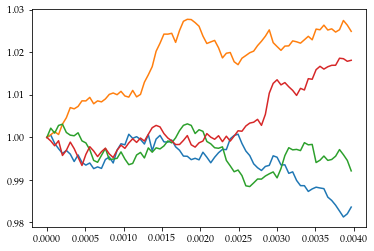

In [39]:
plt.plot(Ts_,Y)

In [ ]:
PnL(dt,dy,A,lbda)